In [1]:
import cv2
import pandas as pd
import numpy as np

CASC_PATH = './data/haarcascade_frontalface_default.xml'
SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
FILE_PATH = './data/fer2013.csv'

cascade_classifier = cv2.CascadeClassifier(CASC_PATH)

data = pd.read_csv(FILE_PATH)

In [2]:
def format_image(data_pixels):

    # From string to numpy array (gray scale image)
    image = np.fromstring(data_pixels, dtype = np.uint8, sep = ' ').reshape((SIZE_FACE, SIZE_FACE))
    
    # cascade classifier needs some gray padding to find the faces
    (lower_bound, higher_bound) = (75-(SIZE_FACE//2), 75+(SIZE_FACE//2))
    gray_border = np.ones((150, 150), np.uint8)*200
    gray_border[lower_bound:higher_bound, lower_bound:higher_bound] = image
    image = gray_border

    # detect faces
    faces = cascade_classifier.detectMultiScale(image, scaleFactor = 1.3, minNeighbors = 5)

    # None is when we don't find an image
    if not len(faces) > 0:
        return None

    # get biggest area face detected
    (w_max,h_max) = (0,0)
    for (x, y, w, h) in faces:
        if w*h > w_max*h_max:
            (x_max,y_max,w_max,h_max) = (x,y,w,h)

    image = image[y_max:(y_max + h_max), x_max:(x_max + w_max)]
    
    # Resize image to network size and normalize values
    image = cv2.resize(image, (SIZE_FACE, SIZE_FACE), interpolation = cv2.INTER_CUBIC) / 255.
       
    return image



In [3]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
data["images"] = data["pixels"].apply(lambda x: format_image(x))

data = data.drop(["pixels", "Usage"], axis=1).dropna(axis=0).reset_index(drop=True)


In [5]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 2 columns):
emotion    13974 non-null int64
images     13974 non-null object
dtypes: int64(1), object(1)
memory usage: 218.4+ KB


,emotion,images
0,0,"[[0.78431372549, 0.772549019608, 0.77254901960..."
1,2,"[[0.78431372549, 0.78431372549, 0.78431372549,..."
2,6,"[[0.78431372549, 0.764705882353, 0.76470588235..."
3,2,"[[0.78431372549, 0.78431372549, 0.76862745098,..."
4,3,"[[0.286274509804, 0.207843137255, 0.2, 0.29803..."


In [6]:
#Save file
data.to_hdf('./data/fer2013.h5', 'data')


/home/charles.xavier.verleyen/yes/envs/emotions-recognition/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['images']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


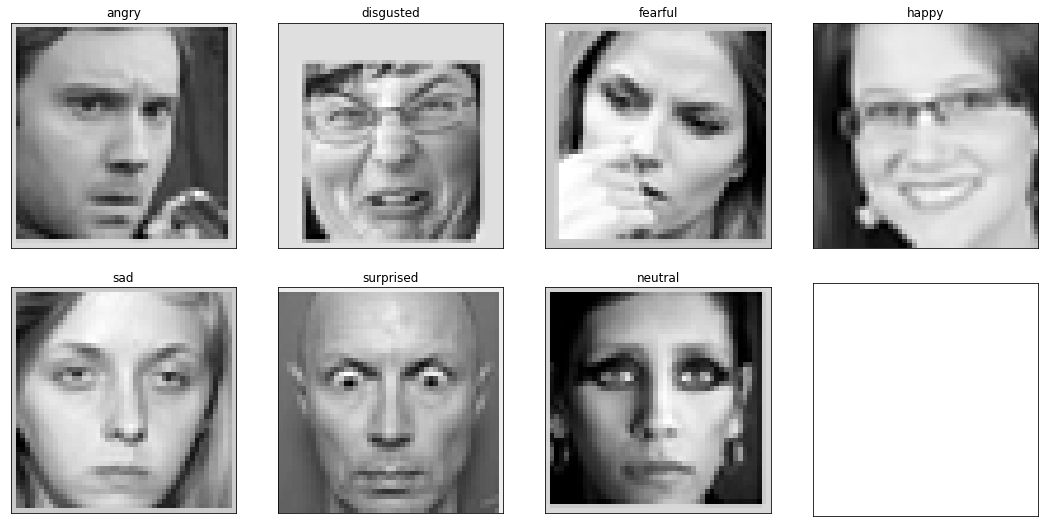

In [7]:
data = pd.read_hdf('./data/fer2013.h5','data')

import matplotlib
from matplotlib import pyplot as plt

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

rows = 2
columns = 4

f, axarr = plt.subplots(rows,columns,figsize=(15,7.5))
f.tight_layout()

for i in range(0,rows):
    for j in range(0,columns):
        if (i*columns+j >= len(EMOTIONS)): 
            break
        img = data.groupby('emotion').first().reset_index()["images"].iloc[i*columns+j]
        emotion = EMOTIONS[data.groupby('emotion').first().reset_index()["emotion"].iloc[i*columns+j]]
        
        axarr[i][j].imshow(img, cmap = 'gray')
        axarr[i][j].set_title(emotion)
        matplotlib.image.imsave(r'./data/image'+ str(i*columns+j) +'.png', img, cmap = 'gray')


plt.setp(axarr, xticks=[], yticks=[]) # to hide tick values on X and Y axis
plt.show()

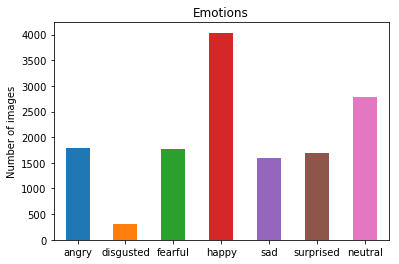

In [8]:
data["emotions"] = data["emotion"].astype('category')
data["emotions"].cat.categories = EMOTIONS

grouped = data.groupby(['emotions'])
grouped.count()["images"].plot(kind='bar', title="Emotions", rot=0)
plt.xlabel("")
plt.ylabel("Number of images")
plt.show()